# Project Description

The data is stored in three files:

gold_recovery_train.csv — training dataset download
gold_recovery_test.csv — test dataset download
gold_recovery_full.csv — source dataset download
Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar.

Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.

The source dataset contains the training and test sets with all the features.

You have the raw data that was only downloaded from the warehouse. Before building the model, check the correctness of the data.

##  Prepare the data

### Open the files and look into the data

In [113]:
#making sure not to see warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [114]:
#importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot as plt

from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler

from joblib import dump

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from numpy.random import RandomState

from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import *
from sklearn.metrics import *

In [115]:
#Let's Load Data
training = pd.read_csv('/datasets/gold_recovery_train.csv')

testing = pd.read_csv('/datasets/gold_recovery_test.csv')

source = pd.read_csv('/datasets/gold_recovery_full.csv')

In [116]:
#Writing function to get a premilinary glence
def read_data(data):
    print(data.head())
    print(data.isna().sum())
    print(data.info())
    print(data.describe())

In [117]:
#printing the list of the column of strings
def str_cols(data, string):
    columns = [col for col in data.columns if string in col]
    print(list(data[columns]))
    return data[columns]

In [118]:
#this function is to calculate recovery
def recover_cal(data,c,f,t):
    calculation = 100 * (data[c] * (data[f] - data[t])) / (data[f] * (data[c] - data[t]))
    return calculation

In [119]:
#to remove the rows with Na
def dropna(a,b):
    data = pd.DataFrame({'a':a, 'b':b}).dropna()
    return data

In [120]:
def rougher(data, metal, rougher, feed, inpu):
    
    au_rougher = str_cols(training,metal)
    au_rougher = str_cols(au_rougher,rougher)
    au_rougher = str_cols(au_rougher,feed)
    au_rougher = str_cols(au_rougher,inpu)
    mean = au_rougher.mean()
    return mean[0]

In [121]:
def concentrate_sum(data,drop1,drop2):
    rougher_input_feed = str_cols(source,'rougher.input.feed')
    rougher_input_feed = rougher_input_feed.drop(drop1,axis=1)
    rougher_input_feed = rougher_input_feed.drop(drop2,axis=1)
    return list(data[rougher_input_feed.columns])

In [122]:
def smape_helper(target, predicted):
    ratio = np.divide(np.abs(target - predicted), (np.abs(target) + np.abs(predicted)) / 2 + 1e-10)  # Adding epsilon to avoid division by zero
    value = np.average(ratio, axis=0)
    return value

def f_smape2(y_true, y_pred):
    predicted_rough, predicted_final = y_pred[:, 1], y_pred[:, 0]
    true_rough, true_final = y_true[:, 1], y_true[:, 0]
    f_smape_value = -1 * (.25 * smape_helper(true_rough, predicted_rough)) + (.75 * smape_helper(true_final, predicted_final))
    return f_smape_value

# Turning our smape function into a scorer for cross-validation
smape_score = make_scorer(f_smape2, greater_is_better=True)

In [124]:
read_data(training)

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

       final.output.concentrate_ag  final.output.concentrate_pb  \
count                 16788.000000                 16788.000000   
mean                      4.716907                     9.113559   
std                       2.096718                     3.389495   
min                       0.000000                     0.000000   
25%                       3.971262                     8.825748   
50%                       4.869346                    10.065316   
75%                       5.821176                    11.054809   
max                      16.001945                    17.031899   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                  16490.000000                 16789.000000   
mean                       8.301123                    39.467217   
std                        3.825760                    13.917227   
min                        0.000000                     0.000000   
25%                        6.939185                    4

In [125]:
read_data(testing)

                  date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   
2  2016-09-01 02:59:59                     215.259946   
3  2016-09-01 03:59:59                     215.336236   
4  2016-09-01 04:59:59                     199.099327   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                        0.990469                             1398.777

In [126]:
read_data(source)

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

       final.output.concentrate_ag  final.output.concentrate_pb  \
count                 22627.000000                 22629.000000   
mean                      4.781559                     9.095308   
std                       2.030128                     3.230797   
min                       0.000000                     0.000000   
25%                       4.018525                     8.750171   
50%                       4.953729                     9.914519   
75%                       5.862593                    10.929839   
max                      16.001945                    17.031899   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                  22331.000000                 22630.000000   
mean                       8.640317                    40.001172   
std                        3.785035                    13.398062   
min                        0.000000                     0.000000   
25%                        7.116799                    4

This is a huge dataset. There might be a lot of issues and null values existing in the dataset. Let's deal with them.

### Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

In [127]:
rougher_training = str_cols(training, 'rougher')
display(rougher_training)

['rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tail_au', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.state.floatb

,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,...,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
1,42050.861809,3498.370979,3489.981857,2.858998,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,...,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2,42018.101184,3495.348910,3502.359819,2.945989,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,...,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147
3,42029.447991,3498.578313,3499.162912,3.002340,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,...,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835
4,42125.354245,3494.800771,3506.679315,3.169615,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,...,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,1401.160227,-450.407128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,45912.942619,2497.652954,2499.177950,1.155559,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,...,1149.807890,-498.789721,1047.963596,-498.413079,946.640977,-499.152477,849.664935,-499.214461,849.758091,-497.448664
16856,46200.099585,2614.403937,2518.550078,1.167342,6.121323,4.144989,559.031805,119.499241,38.591551,4.838619,...,1147.675196,-500.608341,1048.565741,-500.932810,949.773589,-500.023144,848.515225,-500.289405,850.013123,-496.822119
16857,44585.181334,2510.813545,2510.142433,1.125637,5.970515,4.020002,555.682872,122.262690,40.074026,4.525061,...,1149.942902,-501.717903,1049.604390,-500.549053,952.702732,-502.352296,849.016017,-500.505677,850.455635,-506.897968
16858,44084.735708,2507.572494,2507.723361,1.117935,6.048130,3.902537,544.731687,123.742430,39.713906,4.362781,...,1154.087804,-500.036580,1054.009756,-500.237335,944.138793,-496.866953,851.589767,-499.040466,851.345606,-499.122561


In [128]:
C = 'rougher.output.concentrate_au'
F = 'rougher.input.feed_au'
T = 'rougher.output.tail_au'

recover_calc = recover_cal(training,C,F,T)
mae = dropna(recover_calc, training["rougher.output.recovery"])
mae = mean_absolute_error(mae['a'], mae['b'])
print("Mean Absolute Error:", mae)

Mean Absolute Error: 1.0724115653039479e-14


###  Analyze the features not available in the test set. What are these parameters? What is their type?

In [129]:
not_in_test = source.columns.difference(testing.columns)
source[not_in_test].head()
source[not_in_test].isna().sum()

final.output.concentrate_ag                             89
final.output.concentrate_au                             86
final.output.concentrate_pb                             87
final.output.concentrate_sol                           385
final.output.recovery                                 1963
final.output.tail_ag                                    83
final.output.tail_au                                    81
final.output.tail_pb                                   200
final.output.tail_sol                                  271
primary_cleaner.output.concentrate_ag                   98
primary_cleaner.output.concentrate_au                   98
primary_cleaner.output.concentrate_pb                  448
primary_cleaner.output.concentrate_sol                 798
primary_cleaner.output.tail_ag                         102
primary_cleaner.output.tail_au                          99
primary_cleaner.output.tail_pb                         122
primary_cleaner.output.tail_sol                        3

There are nearly 50 features, many of which contain NA values. Depending on the project's requirements, we will address them accordingly.

## Analyze the data

### Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

In [130]:
#Let us create vectors for each element for each stage we care about.
au_rougher_feed = rougher(source,'au','rougher','feed', 'input')
ag_rougher_feed = rougher(source,'ag','rougher','feed', 'input')
pb_rougher_feed = rougher(source,'pb','rougher','feed', 'input')

au_final_output = rougher(source,'au','final','output', 'tail')
ag_final_output = rougher(source,'ag','final','output', 'tail')
pb_final_output = rougher(source,'pb','final','output', 'tail')

au_rougher_output = rougher(source,'au','rougher','output', 'tail')
ag_rougher_output = rougher(source,'ag','rougher','output', 'tail')
pb_rougher_output= rougher(source,'pb','rougher','output', 'tail')

au_primary_output = rougher(source,'au','primary','output','concentrate')
ag_primary_output= rougher(source,'ag','primary','output','concentrate')
pb_primary_output = rougher(source,'pb','final','output','concentrate')

au_final_output_concentrate = rougher(source,'au','final','output','concentrate')
ag_final_output_concentrate = rougher(source,'ag','final','output','concentrate')
pb_final_output_concentrate = rougher(source,'pb','final','output','concentrate')

['final.output.concentrate_au', 'final.output.tail_au', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au', 'secondary_cleaner.output.tail_au']
['rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au']
['rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.input.feed_au']
['rougher.input.feed_au']
['final.output.concentrate_ag', 'final.output.tail_ag', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output

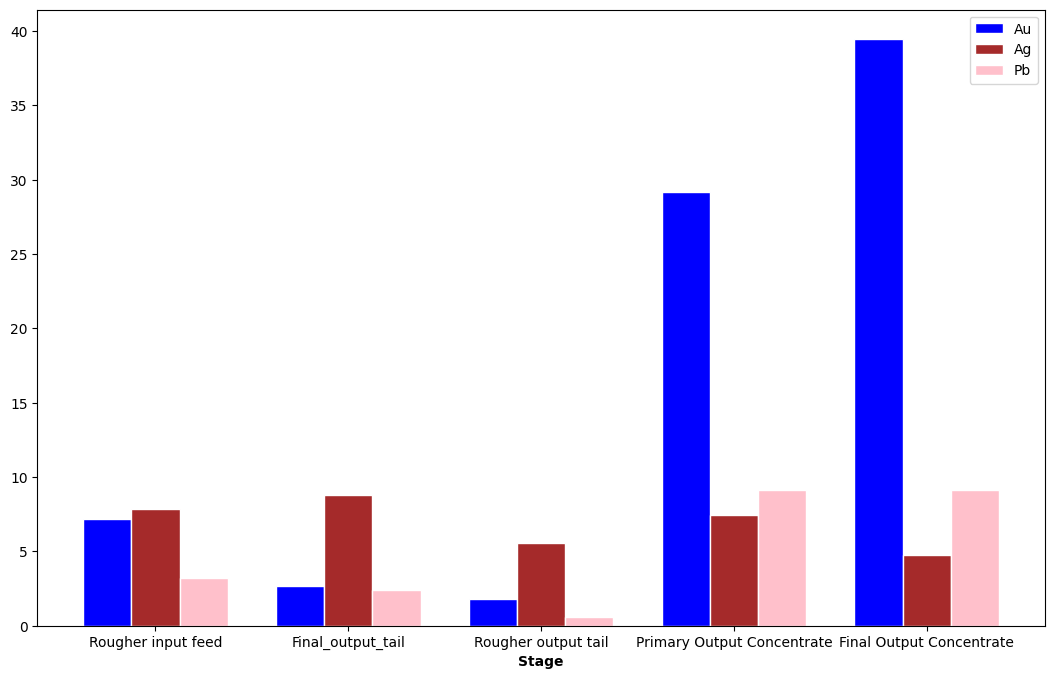

In [131]:
plt.figure(figsize=(13,8), dpi= 100, facecolor='w', edgecolor='k')
labels = ['Au', 'Ag', 'Pb']
bars1 = [au_rougher_feed, au_final_output,au_rougher_output, au_primary_output, au_final_output_concentrate]
bars2 = [ag_rougher_feed, ag_final_output,ag_rougher_output, ag_primary_output, ag_final_output_concentrate]
bars3 = [pb_rougher_feed, pb_final_output,pb_rougher_output, pb_primary_output, pb_final_output_concentrate]

barWidth = 0.25

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='blue', width=barWidth, edgecolor='white', label='Au')
plt.bar(r2, bars2, color='brown', width=barWidth, edgecolor='white', label='Ag')
plt.bar(r3, bars3, color='pink', width=barWidth, edgecolor='white', label='Pb')
 
# Add xticks on the middle of the group bars
plt.xlabel('Stage', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Rougher input feed', 'Final_output_tail', 'Rougher output tail','Primary Output Concentrate', 'Final Output Concentrate'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

The graph provides a clear view of metal concentrations at each stage. It shows that gold's concentration significantly rises from the input stage. Lead's concentration also increases, but to a lesser extent. On the other hand, silver's concentration decreases.

count    16443.000000
mean        58.676444
std         23.922591
min          9.659576
25%         47.575879
50%         54.104257
75%         65.051064
max        484.967466
Name: rougher.input.feed_size, dtype: float64
count    5834.000000
mean       55.937535
std        22.724254
min         0.046369
25%        43.890852
50%        50.002004
75%        61.638434
max       477.445473
Name: rougher.input.feed_size, dtype: float64


<AxesSubplot:>

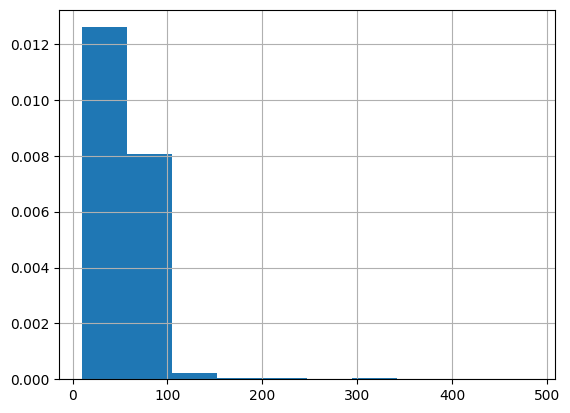

In [132]:
print(training['rougher.input.feed_size'].describe())
print(testing['rougher.input.feed_size'].describe())
training['rougher.input.feed_size'].hist(density=True)

<AxesSubplot:>

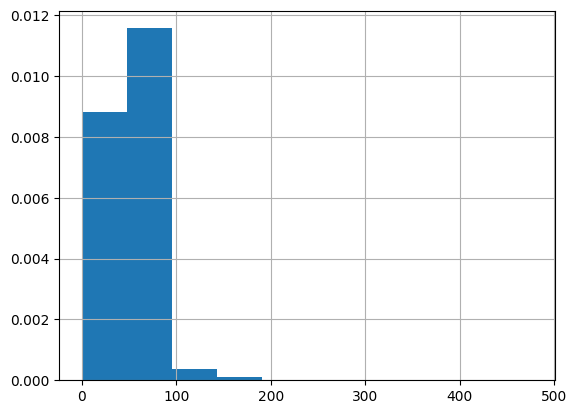

In [133]:
testing['rougher.input.feed_size'].hist(density=True)

### Conclusion:

The `rougher.input.feed_size` distributions in both the training and testing datasets are similar, with both showing right-skewed distributions and close mean and median values. However, the training set has a slightly higher mean and standard deviation. Notably, the testing set has an extremely low minimum value, which may indicate a potential data issue that needs investigation. Overall, the consistency between the datasets supports reliable model training and evaluation, but outliers and data quality should be addressed.

['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au']


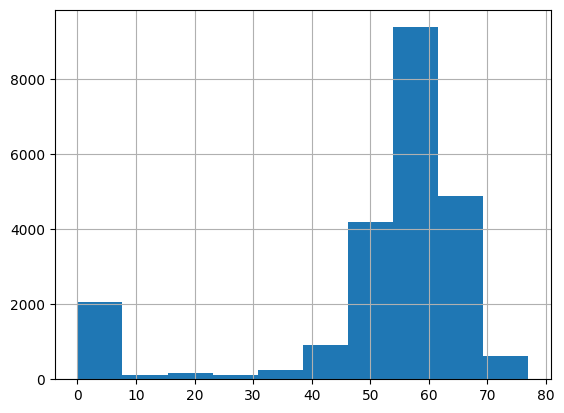

In [134]:
rougher_names = concentrate_sum(source, 'rougher.input.feed_rate', 'rougher.input.feed_size')
source[rougher_names].sum(1).hist()
rougher = source[rougher_names]
#Let us remove rows with only 0
a_series = (rougher != 0).any(axis=1)

rougher = rougher.loc[a_series]

<AxesSubplot:>

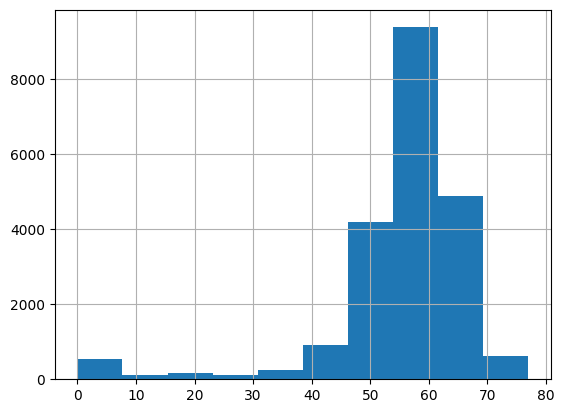

In [135]:
rougher.sum(1).hist()

['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']


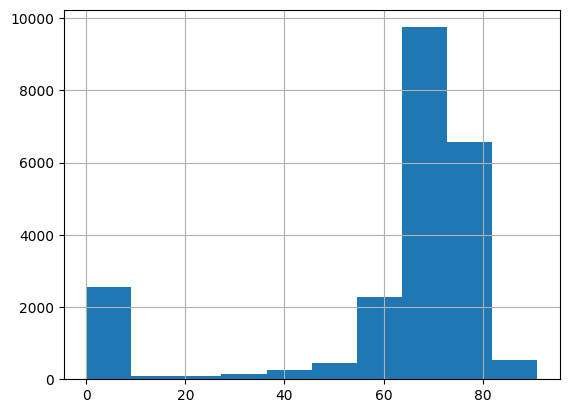

In [136]:
rougher_output_names = str_cols(source,'rougher.output.concentrate').columns
source[rougher_output_names].sum(1).hist()

rougher_output = source[rougher_output_names]
#Let us remove rows with only 0
a_series = (rougher_output != 0).any(axis=1)

rougher_output = rougher_output.loc[a_series]

<AxesSubplot:>

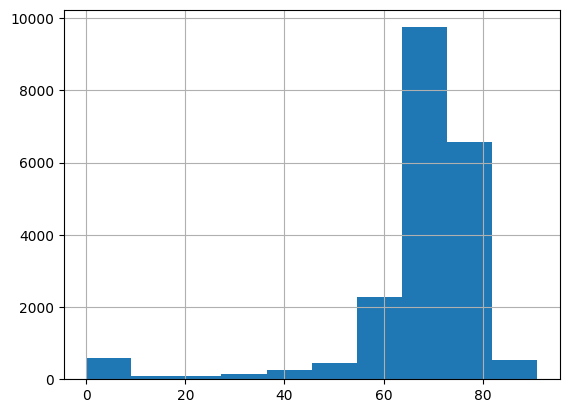

In [137]:
rougher_output.sum(1).hist()

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']


<AxesSubplot:>

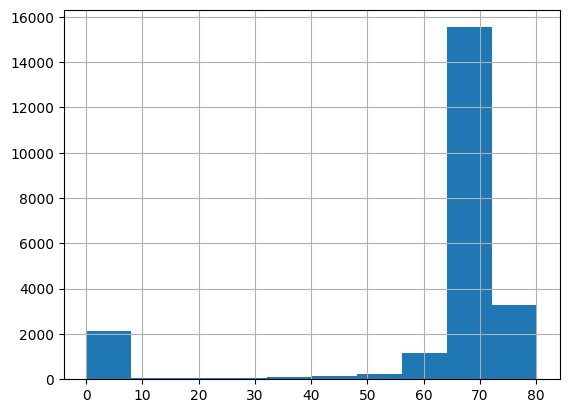

In [138]:
final_output_names = str_cols(source,'final.output.concentrate').columns
source[final_output_names].sum(1).hist()

<AxesSubplot:>

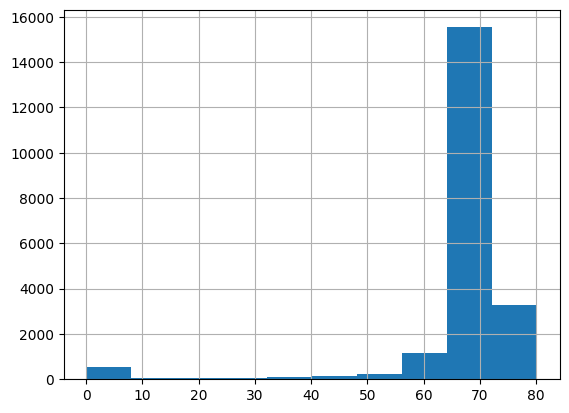

In [139]:
final_output = source[final_output_names]
#Let us remove rows with only 0
a_series = (final_output != 0).any(axis=1)

final_output = final_output.loc[a_series]
final_output.sum(1).hist()

Overall, these histograms help in understanding the distribution of input and output values in the rougher and final stages of the process. The right-skewness indicates that while most of the values are low, there are some higher values that are less frequent. This could be indicative of the nature of the material processing, where most instances have low values, but there are occasional instances with higher values.

## Build the model

### Write a function to calculate the final sMAPE value.

### Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

In [144]:
target = ['rougher.output.recovery', 'final.output.recovery']
features = list(set(training.columns).intersection(set(testing.columns)).difference(set(target)))

features.remove('date')

# Merge targets with the test set using 'date' as the key
test = testing.merge(source[target + ['date']], how='left', on='date')

# Drop rows with NaN values from both training and test sets
train = training.dropna(subset=target + features)
test = test.dropna(subset=target + features)

In [148]:
# Extract feature and target arrays for training and testing
features_train = train[features].values
target_train = train[target].values

features_test = test[features].values
target_test = test[target].values

In [149]:
# Linear regression
model1 = LinearRegression()  # Initialize model constructor
model1.fit(features_train, target_train)  # Train model on training set

# Cross-validation using final smape as scoring
scores1 = cross_val_score(model1, features_train, target_train, scoring=smape_score, cv=5)

final_score1 = sum(scores1) / len(scores1)
print('Average model evaluation score:', final_score1)



Average model evaluation score: 0.053967919522758034


In [150]:
# Decision Tree
model2 = DecisionTreeRegressor(random_state=12345)
model2.fit(features_train, target_train) # train model on training set

# Cross validation using final smape as scoring
scores2 = cross_val_score(model2, features_train, target_train, scoring=smape_score, cv=5) 
final_score2 = sum(scores2) / len(scores2)
print('Average model evaluation score:', final_score2)



Average model evaluation score: 0.10385259020047292


In [151]:
# Random forest 
model3 = RandomForestRegressor(random_state=12345)
model3.fit(features_train, target_train) # train model on training set

# Cross validation using final smape as scoring
scores3 = cross_val_score(model3, features_train, target_train, scoring=smape_score, cv=5) 
final_score3 = sum(scores3) / len(scores3)
print('Average model evaluation score:', final_score3)



Average model evaluation score: 0.0658699735201919


In [152]:
# creating a dummy regressor to mimic a constant model that always predicts mean of the train set targets
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(features_train, target_train)
dummy_predictions = dummy_regressor.predict(features_test)
f_smape2(target_test, dummy_predictions)

0.05073641448132953

In [153]:
# final model 
final_model = RandomForestRegressor(random_state=12345)
final_model.fit(features_train, target_train)
final_predictions = final_model.predict(features_test)
result = f_smape2(target_test, final_predictions)
print('Final sMAPE score of test data: ', result) 

Final sMAPE score of test data:  0.06458921032546172


# Conclusion

Overall, we successfully handled the provided data to complete the project. We verified the correctness of the recovery column by comparing it with our calculated values. We examined the metal concentration distributions, identified and removed anomalies. The data showed increased gold concentrations in the final product and a small amount of gold in the tails. We analyzed gold recovery and compared it with other metals. Ultimately, we trained a model to predict gold recovery and found the decision tree to be the best performing model. Zyfra can use this model to optimize their gold ore refining process.